In [ ]:
#pip install matplotlib numpy pandas seaborn scikit-learn tensorflow keras kaggle kagglehub

  Using cached matplotlib-3.10.3-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached kaggle-1.7.4.5-py3-none-any.whl.metadata (16 kB)
  Using cached contourpy-1.3.2-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/108.5 kB ? eta -:--:--
     --- ------------------------------------ 10.2/108.5 kB ? eta -:--:--
     ------------- ----------------------- 41.0/108.5 kB 393.8 kB/s eta 0:00:01
     ------------------------ ------------ 71.7/108.5 kB 563.7 kB/s eta 0:00:01
     ------------------------------------ 108.5/108.5 kB 629.7 kB/s eta 0:00:00
  Using cached pillow-11.2.1-cp311-cp311-win_amd64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 k


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#pip install --upgrade tensorflow keras


  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.9 MB 1.9 MB/s eta 0:03:16
   ---------------------------------------- 0.1/375.9 MB 656.4 kB/s eta 0:09:33
   ---------------------------------------- 0.2/375.9 MB 1.3 MB/s eta 0:04:47
   ---------------------------------------- 0.2/375.9 MB 1.1 MB/s eta 0:05:33
   ---------------------------------------- 0.4/375.9 MB 2.0 MB/s eta 0:03:12
   ---------------------------------------- 0.5/375.9 MB 2.0 MB/s eta 0:03:12
   ---------------------------------------- 1.0/375.9 MB 3.0 MB/s eta 0:02:04
   ---------------------------------------- 1.2/375.9 MB 3.4 MB/s eta 0:01:50
   ---------------------------------------- 2.0/375.9 MB 5.0 MB/s eta 0:01:16
   -----------------

  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Acesso negado: 'c:\\Users\\João Carvalho\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\tensorflow\\compiler\\mlir\\quantization\\tensorflow\\python\\pywrap_quantize_model.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# bibliotecas
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

import os
from enum import Enum
from typing import Tuple, Callable
from kagglehub import dataset_download

In [16]:
__ONLINE_DATASET_URI = "birdy654/cifake-real-and-ai-generated-synthetic-images"
__BASE_LOCAL_DATA_PATHS = [
    ("../data/train/REAL", 50000),
    ("../data/train/FAKE", 50000),
    ("../data/test/REAL", 10000),
    ("../data/test/FAKE", 10000)
]

class ModelType(Enum):
    GENERAL = "general"
    EFFICIENTNET_B0 = "efficientnet_b0"
    RESNET50 = "resnet50"
    XCEPTION = "xception"
    MOBILENET_V2 = "mobilenet_v2"
    SHUFFLENET_V2 = "shufflenet_v2"

def _get_tf_preprocess_fn(model_type: ModelType,
                          resize_to: Tuple[int, int]) -> Callable[[tf.Tensor, tf.Tensor], Tuple[tf.Tensor, tf.Tensor]]:
    def preprocess(image: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        image = tf.image.resize(image, resize_to)
        image = tf.cast(image, tf.float32) / 255.0

        if model_type in [ModelType.EFFICIENTNET_B0, ModelType.RESNET50]:
            mean = tf.constant([0.485, 0.456, 0.406])
            std = tf.constant([0.229, 0.224, 0.225])
            image = (image - mean) / std
        elif model_type in [ModelType.MOBILENET_V2]:
            image = (image - 0.5) * 2.0
        return image, label
    return preprocess

def load_and_preprocess_data_tf(resize_to: Tuple[int, int] = (224, 224),
                                batch_size: int = 32,
                                model_type: ModelType = ModelType.GENERAL,
                                manual_path: str = None) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    if manual_path is not None:
        train_path = os.path.join(manual_path, "train")
        test_path = os.path.join(manual_path, "test")
    else:
        train_path = "../data/train"
        test_path = "../data/test"


    preprocess_fn = _get_tf_preprocess_fn(model_type, resize_to)

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=resize_to,
        batch_size=batch_size,
        shuffle=True
    ).map(preprocess_fn).prefetch(tf.data.AUTOTUNE)

    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_path,
        image_size=resize_to,
        batch_size=batch_size,
        shuffle=False
    ).map(preprocess_fn).prefetch(tf.data.AUTOTUNE)

    return train_ds, test_ds


In [ ]:
#meu pc (joão) virou uma batata pelo acento no meu nome
'''import os
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi

# Caminhos absolutos no Windows
origem = r"C:\Users\João Carvalho\Desktop\vou me matar\kaggle.json"
destino = r"C:\Users\João Carvalho\.kaggle\kaggle.json"

# Cria a pasta .kaggle se não existir
os.makedirs(os.path.dirname(destino), exist_ok=True)

# Copia o arquivo
shutil.copy(origem, destino)

# Usa a API normalmente
api = KaggleApi()
api.authenticate()
api.dataset_download_files('birdy654/cifake-real-and-ai-generated-synthetic-images', path='cifake', unzip=True)

print(os.listdir("cifake"))
'''

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
['test', 'train']


In [17]:
train_path = "/content/cifake/train"
test_path = "/content/cifake/test"


### Carregamento e Pré-Processamento do Dataset

In [18]:
batch_size = 32
image_size = (224, 224)
pi = "C:/TT"
train_ds, test_ds = load_and_preprocess_data_tf(
    resize_to=image_size,
    batch_size=batch_size,
    model_type=ModelType.MOBILENET_V2,
    manual_path = r"C:/TT/cifake"

)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


### Divisão Holdout

In [19]:
total_batches = tf.data.experimental.cardinality(train_ds).numpy()
total_samples = total_batches * batch_size

In [20]:
# Define proporção de treino (70%) e validação (30%) usando o número de batches
train_batches = int(total_batches * 0.7)
val_batches = total_batches - train_batches

In [21]:
# Embaralha os batches do dataset
train_ds_shuffled = train_ds.shuffle(buffer_size=1000, seed=42, reshuffle_each_iteration=False)

In [22]:
# Divisão trenio e validação
train_ds = train_ds_shuffled.take(train_batches)
val_ds = train_ds_shuffled.skip(train_batches)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [23]:
print(f"Batches de treino: {train_batches}")
print(f"Batches de validação: {val_batches}")
print(f"Aproximadamente {train_batches * batch_size} amostras de treino")
print(f"Aproximadamente {val_batches * batch_size} amostras de validação")

Batches de treino: 2187
Batches de validação: 938
Aproximadamente 69984 amostras de treino
Aproximadamente 30016 amostras de validação


## Treino

### Modelo

**ResNet50**

O ResNet50 é uma arquitetura de rede neural convolucional profunda de ponta, desenvolvida pela Microsoft Research em 2015. É uma variante da popular arquitetura ResNet e compreende 50 camadas que permitem o aprendizado de arquiteturas muito mais profundas do que era possível anteriormente, sem o problema de gradientes que desaparecem.

A arquitetura do ResNet50 é dividida em quatro partes principais: as camadas convolucionais, o bloco de identidade, o bloco convolucional e as camadas totalmente conectadas. As camadas convolucionais são responsáveis ​​por extrair características da imagem de entrada, o bloco de identidade e o bloco convolucional processam e transformam essas características, e as camadas totalmente conectadas fazem a classificação final. O ResNet50 foi treinado no grande conjunto de dados ImageNet, alcançando uma taxa de erro equivalente ao desempenho humano, tornando-o um modelo poderoso para diversas tarefas de classificação de imagens, como detecção de objetos, reconhecimento facial e análise de imagens médicas. Além disso, também tem sido usado como um extrator de características para outras tarefas, como detecção de objetos e segmentação semântica.

Fonte: https://medium.com/@nitishkundu1993/exploring-resnet50-an-in-depth-look-at-the-model-architecture-and-code-implementation-d8d8fa67e46f

In [24]:
device = "GPU" if len(tf.config.list_physical_devices("GPU")) > 0 else "CPU"
print(f"Usando: {device}")

Usando: CPU


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

tf.debugging.set_log_device_placement(True)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    steps_per_epoch=1000,
    validation_steps=250,
    callbacks=[early_stopping]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2340033 (8.93 MB)
Trainable params: 8204

5000/5000 [==============================] - 228s 45ms/step


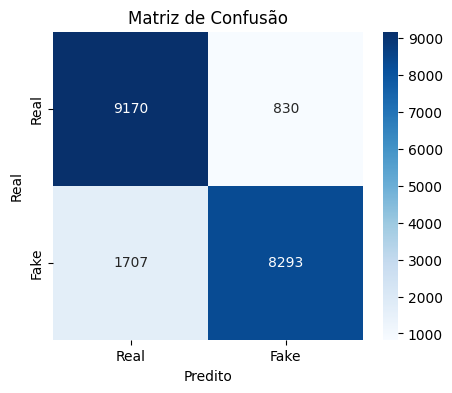


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.84      0.92      0.88     10000
        Fake       0.91      0.83      0.87     10000

    accuracy                           0.87     20000
   macro avg       0.88      0.87      0.87     20000
weighted avg       0.88      0.87      0.87     20000

AUC (ROC): 0.9503


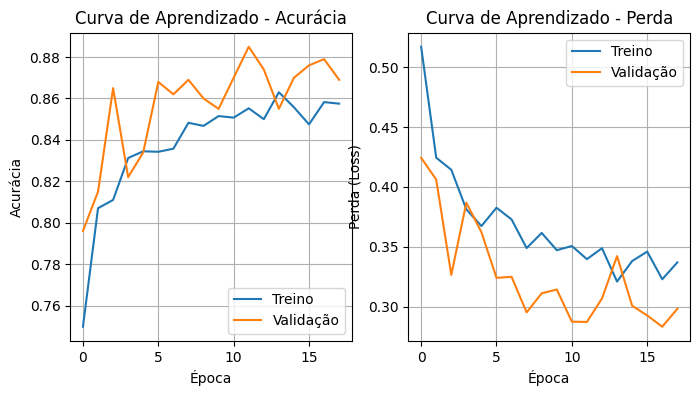

In [14]:
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Extrair labels verdadeiros do dataset de teste
y_test = []
for _, labels in test_ds:
    y_test.extend(labels.numpy())
y_test = np.array(y_test)

# Flatten y_pred_prob para garantir formato correto
y_pred_prob = y_pred_prob.ravel()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC (ROC): {roc_auc:.4f}")

plt.figure(figsize=(8, 4))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Curva de Aprendizado - Acurácia")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.grid()

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Curva de Aprendizado - Perda")
plt.xlabel("Época")
plt.ylabel("Perda (Loss)")
plt.legend()
plt.grid()

plt.show()

In [ ]:
import json
with open('history_effct.json', 'w') as f:
    json.dump(history.history, f)

In [15]:
model.save("MobileNet.keras")